In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

np.random.seed(42)

In [2]:
from TestCaseGenerator import data_RLClustering
X, M, T_P, N, d = data_RLClustering(4)

In [22]:

beta_min = 0.1
beta_max = 10000.0
tau = 1.5


rho = np.ones(N) / N  # Uniform weights

# Initialize cluster centers randomly
Y = np.random.randn(M, 2)

# Random probabilities p(l | j, i): shape (M, M, N)
p_l_given_ji = np.full((N, M, M), 0.2 / (M - 1))
for i in range(N):
    for k in range(M):
        p_l_given_ji[i, k, :] = 0.2 / (M - 1)
        p_l_given_ji[i, k, k] = 0.8
# Normalize so that sum over l is 1 for each (i, k)
p_l_given_ji /= np.sum(p_l_given_ji, axis=2, keepdims=True)

In [ ]:
import numpy as np

def compute_cluster_centers(X, rho, pi, p_l_given_ji, eps=1e-12):
    """
    Compute Y (M x d) where
      y_l = sum_{i,j} rho[i] * p_l_given_ji[i,j,l] * pi[i,j] * x_i
            --------------------------------------------------------
            sum_{i,j} rho[i] * p_l_given_ji[i,j,l] * pi[i,j]

    Parameters
    ----------
    X : (N, d) array
    rho : (N,) array
    pi : (N, M) array  # pi[i,j] = pi(j|i)
    p_l_given_ji : (N, M, M) array  # p_l_given_ji[i,j,l] = p(l|j,i)
    eps : small float to avoid division by zero (default 1e-12)

    Returns
    -------
    Y : (M, d) array of cluster centers
    """
    # shapes
    N, d = X.shape
    assert rho.shape == (N,)
    assert pi.ndim == 2 and pi.shape[0] == N
    assert p_l_given_ji.shape[0] == N and p_l_given_ji.shape[1] == pi.shape[1]
    M = pi.shape[1]
    assert p_l_given_ji.shape[2] == M

    W = rho[:, None, None] * pi[:, :, None] * p_l_given_ji  # shape (N, M, M) with axis-2 = l

    # numerator: sum_{i,j} W[i,j,l] * X[i]  -> shape (M, d)
    numerator = np.einsum('ijl,id->ld', W, X)

    # denominator: sum_{i,j} W[i,j,l] -> shape (M,)
    denom = np.einsum('ijl->l', W)

    # avoid division by zero
    denom_safe = denom + (denom == 0) * eps

    Y = numerator / denom_safe[:, None]


    return Y


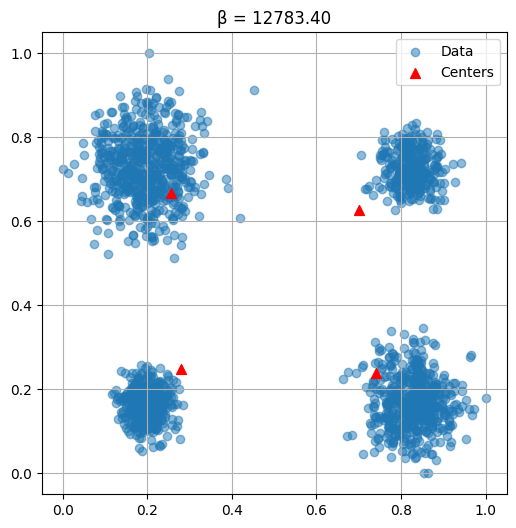

In [24]:
# Cell 4: Main loop with policy and y_l updates
beta = beta_min
Y_old = Y.copy() + 1e6
Y_list = []
pi_list = []
while beta <= beta_max:
    counter = 0
    while np.linalg.norm(Y - Y_old) / np.linalg.norm(Y_old) > 1e-6:
        # update policy
        D = cdist(X, Y, "sqeuclidean", out=None)
        D_bar = np.sum(np.tile(D[:, None, :], (1, M, 1)) * p_l_given_ji, axis=2)
        mins = np.min(D_bar, axis=1, keepdims=True)
        D_bar_normalized = D_bar - mins
        pi = np.exp(-beta * D_bar_normalized)
        pi /= np.sum(pi, axis=1, keepdims=True)
        # update cluster centers
        Y = compute_cluster_centers(X, rho, pi, p_l_given_ji, eps=1e-12)

        counter += 1
        Y_old = Y.copy()
    Y_list.append(Y)
    pi_list.append(pi)
    beta *= tau
    Y += np.random.randn(M, 2) * 0.001  # Add small noise to avoid local minima
    # print(
    #         f"Iteration {counter}, beta: {beta:.2f}, norm: {np.linalg.norm(Y - Y_old):.6f}"
    #     )
    # Plot for GIF
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Data")
ax.scatter(Y[:, 0], Y[:, 1], color="red", s=50, marker="^", label="Centers")
ax.set_title(f"β = {beta:.2f}")
ax.legend()
ax.grid(True)

In [25]:
from animator import animate_Clusters

animate_Clusters(
    X,
    Y_list,
    pi_list,
    figuresize=(6, 5),
    interval=400,
    save_path="phase_transition_clustering.gif",
)